In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv(r'E:\Programming\Python\Dataset\SMS_Classification\train-data.tsv', sep="\t", header=None, names=['y', 'x'])
df_train.head()

,y,x
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...


In [3]:
df_test = pd.read_csv(r'E:\Programming\Python\Dataset\SMS_Classification\valid-data.tsv', sep="\t", header=None, names=['y', 'x'])
df_test.head()

,y,x
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?


In [4]:
print(len(df_train))
print(len(df_test))

4179
1392


In [5]:
y_train = df_train['y'].astype('category').cat.codes
y_test  = df_test['y'].astype('category').cat.codes
y_train[:5]

0    0
1    0
2    0
3    0
4    0
dtype: int8

Text(0.5, 1.0, 'Number of ham and spam messages')

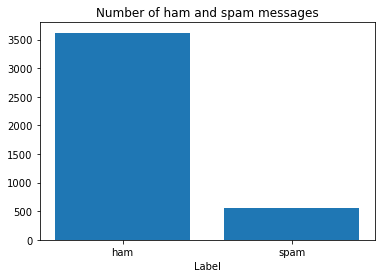

In [6]:
bar = df_train['y'].value_counts()

plt.bar(bar.index, bar)
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [7]:
import nltk
nltk.download('stopwords') # download stopwords
nltk.download('wordnet')   # download vocab for lemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\OJASH\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\OJASH\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

In [9]:
stopwords_eng = set(stopwords.words('english'))
len(stopwords_eng)

179

In [10]:
lemmatizer = WordNetLemmatizer()

def clean_txt(txt):
    txt = re.sub(r'([^\s\w])+', ' ', txt)
    txt = " ".join([lemmatizer.lemmatize(word) for word in txt.split()
                    if not word in stopwords_eng])
    txt = txt.lower()
    return txt

In [11]:
X_train = df_train['x'].apply(lambda x: clean_txt(x))
X_train[:5]

0    ahhhh woken bad dream u tho dont like u right ...
1                                        never nothing
2    u sound like manky scouse boy steve like trave...
3    mum say wan go go shun bian watch da glass exh...
4    never lei v lazy got wat dat day ü send da url...
Name: x, dtype: object

In [12]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

Using TensorFlow backend.


In [13]:
# Keep top 1000 frequently occurring words
max_words = 1000

# Cut off the words after seeing 500 words in each document
max_len = 500

In [14]:
t = Tokenizer(num_words=max_words)
t.fit_on_texts(X_train)

In [15]:
# Transform each text to a sequence of integers
sequences = t.texts_to_sequences(X_train)
sequences[:5]

[[309, 227, 1, 587, 42, 15, 1, 90, 359, 13, 103, 54, 228, 86],
 [195, 252],
 [1, 310, 15, 219, 15, 43, 311, 37, 386, 1, 6, 338, 422],
 [477, 58, 188, 8, 8, 243, 43],
 [195, 478, 167, 821, 18, 77, 212, 12, 28, 22, 43, 124, 70, 24]]

In [16]:
# Make all rows of equal length
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
sequences_matrix[:5]

array([[  0,   0,   0, ...,  54, 228,  86],
       [  0,   0,   0, ...,   0, 195, 252],
       [  0,   0,   0, ...,   6, 338, 422],
       [  0,   0,   0, ...,   8, 243,  43],
       [  0,   0,   0, ..., 124,  70,  24]])

In [17]:
i = tf.keras.layers.Input(shape=[max_len])
x = tf.keras.layers.Embedding(max_words, 50, input_length=max_len)(i)
x = tf.keras.layers.LSTM(64)(x)

x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(1, activation='relu')(x)

model = tf.keras.models.Model(inputs=i, outputs=x)
model.compile(
    loss='binary_crossentropy',
    optimizer='RMSprop',
    metrics=['accuracy']
)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 96,337
Trainable params: 96,337
Non-trainable params: 0
_________________________________________________________

In [18]:
r = model.fit(sequences_matrix, y_train,
              batch_size=128, epochs=20,
              validation_split=0.2,
              callbacks=[tf.keras.callbacks.EarlyStopping(
                  monitor='val_loss', min_delta=0.0001)])


Train on 3343 samples, validate on 836 samples
Epoch 1/20
3343/3343 [==============================] - 3s 953us/sample - loss: 0.4140 - accuracy: 0.8672 - val_loss: 0.2696 - val_accuracy: 0.8612
Epoch 2/20
3343/3343 [==============================] - 1s 227us/sample - loss: 0.1707 - accuracy: 0.9109 - val_loss: 0.0964 - val_accuracy: 0.9797
Epoch 3/20
3343/3343 [==============================] - 1s 215us/sample - loss: 0.0683 - accuracy: 0.9803 - val_loss: 0.1052 - val_accuracy: 0.9844


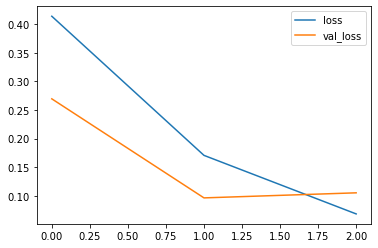

In [19]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

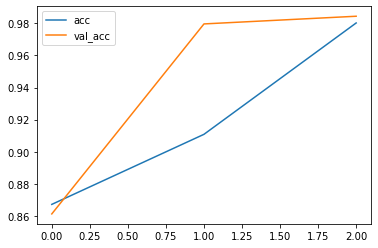

In [20]:
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

In [21]:
def preprocessing(X):
  x = X.apply(lambda x: clean_txt(x))
  x = t.texts_to_sequences(x)
  return sequence.pad_sequences(x, maxlen=max_len)

In [22]:
s = model.evaluate(preprocessing(df_test['x']), y_test)

1392/1392 [==============================] - 0s 261us/sample - loss: 0.0602 - accuracy: 0.9878


In [23]:
print('Loss: {:.3f}, Accuracy: {:.3f}'.format(s[0], s[1]))

Loss: 0.060, Accuracy: 0.988


In [24]:
# Function to check if the given text is SPAM or HAM and what percentage
def predict_message(pred_text):
  p = model.predict(preprocessing(pd.Series([pred_text])))[0]

  return (p[0], ("ham" if p<0.5 else "spam"))

pred_text = "sale today! to stop texts call 98912460324"

prediction = predict_message(pred_text)
print(prediction)

(0.81737036, 'spam')
